<strong>I made use of few kernels on kaggle</strong>
<ol>
    <li>https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert</li>
    <li>https://www.kaggle.com/datark1/disaster-tweets-eda-tokenization-xgboost</li>
    
</ol>    

## Problem Statement

<p>Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).But, it’s not always clear whether a person’s words are actually announcing a disaster.
So our work is to build a model that predicts whether given tweet is real or fake disaster
</p>

## Importing Libraries

In [1]:
import re
import numpy as np
import pandas as pd
import spacy
import seaborn as sns
from tqdm import tqdm,tqdm_gui,tqdm_notebook,tqdm_pandas,tnrange
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from collections import Counter
import nltk
import string


## Loading Data

In [2]:
data = pd.read_csv('data/train.csv')
print('Shape of the data :',data.shape)
print('Columns :',data.columns)
data.head()

Shape of the data : (7613, 5)
Columns : Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


<strong>Location and keword columns seems to have missing values</strong>


<strong>id</strong> - a unique identifier for each tweet<br>
<strong>text</strong> - the text of the tweet<br>
<strong>location </strong>- the location the tweet was sent from (2533 blank values)<br>
<strong>keyword</strong> - a particular keyword from the tweet (61 blank values)<br>
<strong>target</strong> - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [4]:
print('Shape of the data before dropping duplicates',data.shape)
data.drop_duplicates(inplace=True)
print('Shape of the data after dropping duplicates',data.shape)

Shape of the data before dropping duplicates (7613, 5)
Shape of the data after dropping duplicates (7613, 5)


## Exploratory Data Analysis

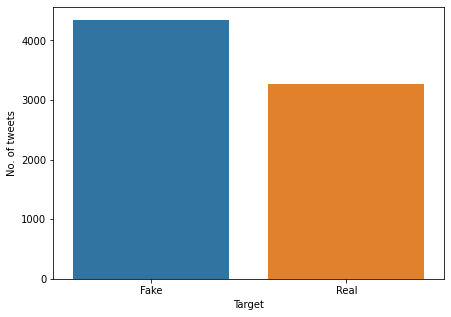

In [5]:
plt.figure(figsize = (7,5))
target_plot = sns.barplot(['Fake','Real'],data.target.value_counts().values)
target_plot.set_xlabel('Target')
target_plot.set_ylabel('No. of tweets')
plt.savefig('plots/class_count.png')
plt.show()

<strong>Key take away:</strong>
<p>
    Since the dataset is having almost balanced class labels we can use  accuracy as the metric for selecting best model.

</p>
    

In [6]:
class eda:
    def __init__(self,data,column,plot_save_path='plots/',target = 'target'):
        '''
            Given a data and a  column of the data we can perform basic eda operations like
            frequency of values in given column, probability distribution of given column
            Note: for probability distribution the column must be an int dtype.
            
            data  : dataframe
            column: column name on which you want to perform frequency or probability distribution
            plot_save: path to save the plots
            target   : target/label column of the data set/frame
        '''
        self.data = data
        self.target = target
        self.column = column
        self.plot_save_path = plot_save_path
        self.top_ = 0
        self.real_top = 0
        self.fake_top = 0
    def freq_plot(self,type_='real',top=50):
        '''
            Plots frequency/occurance of the column values
            
            type_    : if real perform frequency plot is for 1 class(positive class) 
                       if fake perform frequency plot is for 0 class(negative class) 
                       if all  perform frequency plot is for all classes
            top      : shows top number of values
            
                    
        '''
        if type_ == 'all':
            
            plt.figure(figsize = (15,5))
            self.top_ = self.data[self.column].value_counts()
            
            plot_ = sns.barplot(self.top_[:top].index,self.top_[:top].values)
            
        elif type_ == 'real':
            plt.figure(figsize = (15,5))
            self.real_top = self.data[self.data[self.target] == 1][self.column].value_counts()
            plot_ = sns.barplot(self.real_top[:top].index,self.top_[:top].values)
            
        elif type_ == 'fake':
            plt.figure(figsize = (15,5))
            self.fake_top = self.data[self.data[self.target] == 0][self.column].value_counts()
            
            plot_ = sns.barplot(self.fake_top[:top].index,self.top_[:top].values)

        else:
            print('Invalied type:{}'.format(type_))
            
        plt.xlabel(self.column.upper())
        plt.ylabel('Frequency')
        plt.title('Top {} {} {}'.format(top,type_,self.column))
        plt.xticks(rotation=90)
        plt.savefig(self.plot_save_path+'Top {} {} {}'.format(top,type_,self.column)+'.png')
        plt.show()
            
            
    def word_cloud(self,type_='real'):
        
        '''
            Plots wordcloud of the column values
            
            type_    : if real perform wordcloud for 1 class(positive class) 
                       if fake perform wordcloud for 0 class(negative class) 
                       if all  perform wordcloud for all classes
                    
        '''
        
        if type_ == 'all':
            
            plt.figure(figsize = (15,7))
            text = ' '.join([str(word) for  word in list(self.data[self.column].values)])
            wc = WordCloud(width=1000,height=800,collocations=False).generate_from_text(text)
            
            
        elif type_ == 'real':
            plt.figure(figsize = (15,7))
            text = ' '.join([str(word) for  word in list(self.data[self.data[self.target] == 1][self.column].values)])
            wc = WordCloud(width=1000,height=800,collocations=False).generate_from_text(text)
            
        elif type_ == 'fake':
            plt.figure(figsize = (15,7))
            text = ' '.join([str(word) for  word in list(self.data[self.data[self.target] == 0][self.column].values)])
            wc = WordCloud(width=1000,height=800,collocations=False).generate_from_text(text)

        else:
            print('Invalied type:{}'.format(type_))
            
        plt.title('{}  {}'.format(type_,self.column))
        plt.imshow(wc)
        plt.savefig(self.plot_save_path+'Top  {} {} wc'.format(type_,self.column)+'.png')
        plt.show()
            
            
            
            
    def dist_plot(self):
            
        '''
            Plots distribution plot for  given column of the data, column must be an dtype of int
        '''
        
        if not self.data[self.column].dtype == 'O':
    
            sns.FacetGrid(data = self.data,hue=self.target,height=7).map(sns.distplot,self.column).add_legend()
            plt.show()

### Keywords

In [7]:
# Printing few keywords
for  i in range(10):
    r  = np.random.randint(data.shape[0])
    print(data.keyword.iloc[r])
    print('---'*10)
    

sinking
------------------------------
wrecked
------------------------------
deluge
------------------------------
destroy
------------------------------
flattened
------------------------------
drowning
------------------------------
hurricane
------------------------------
lightning
------------------------------
drown
------------------------------
armageddon
------------------------------


In [8]:
# Checking for nan values
data.keyword.fillna('nan').value_counts()

nan                      61
fatalities               45
armageddon               42
deluge                   42
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

<strong>There are only 61 nan values for keywords, so there is no need of nan values to replace</strong>

In [9]:
print("i.e {:.2f}%  of them are nan values".format(61/data.shape[0]))

i.e 0.01%  of them are nan values


<strong>There are 221 unique keywords</strong>

#### All Keywords

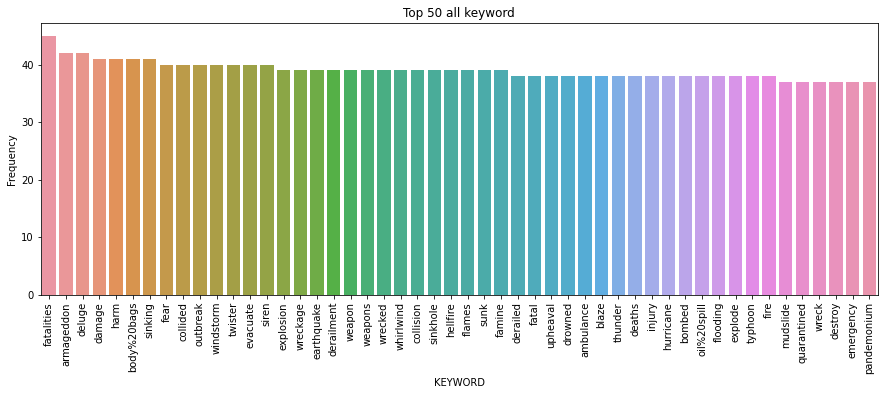

In [10]:
keywords = eda(data,'keyword',)
keywords.freq_plot('all',top=50)

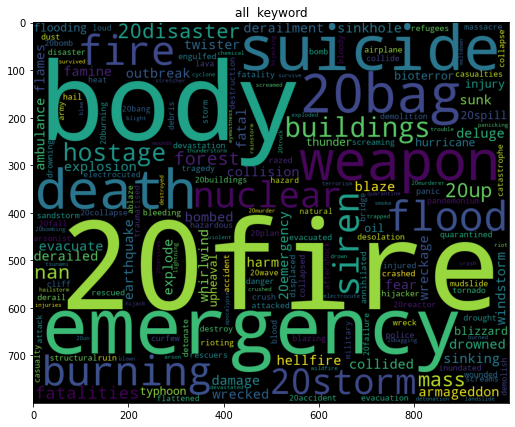

In [11]:
keywords.word_cloud('all')

#### Real Keywords

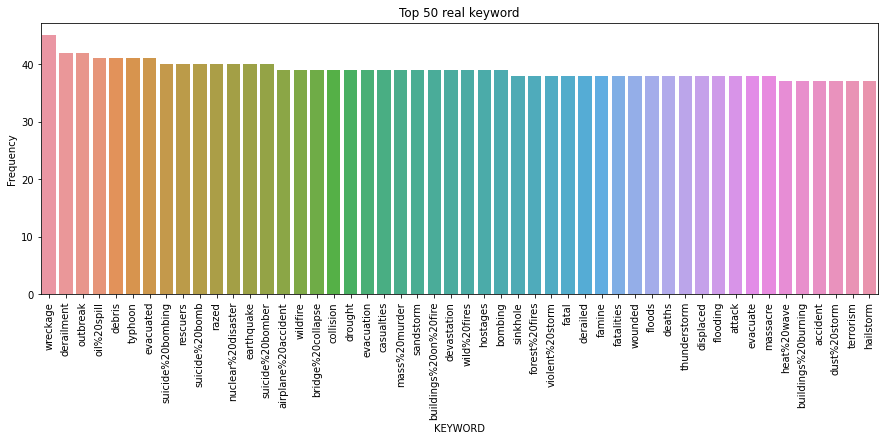

In [12]:
keywords.freq_plot('real')


<strong>If we see barplot and word cloud there is %20 that is joining the words which must be cleaned</strong><br>
For example forest%20fire must be replaced with forest_fire or forestfire
        

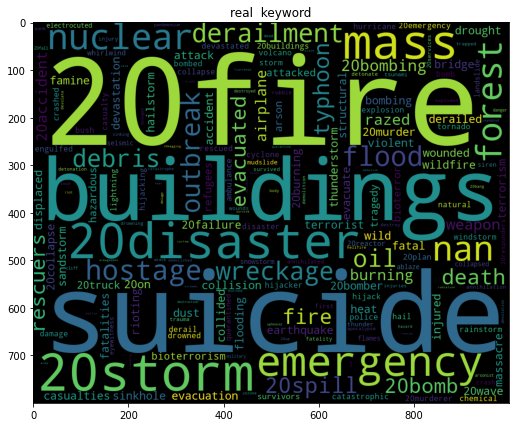

In [13]:
keywords.word_cloud('real')

##### Observations
<ol>
     The words present for column keywords in whose target label is real are
    <li>suicide</li>
    <li>fire</li>
    <li>buildings etc</li>
    
</ol>    


#### Fake Keywords

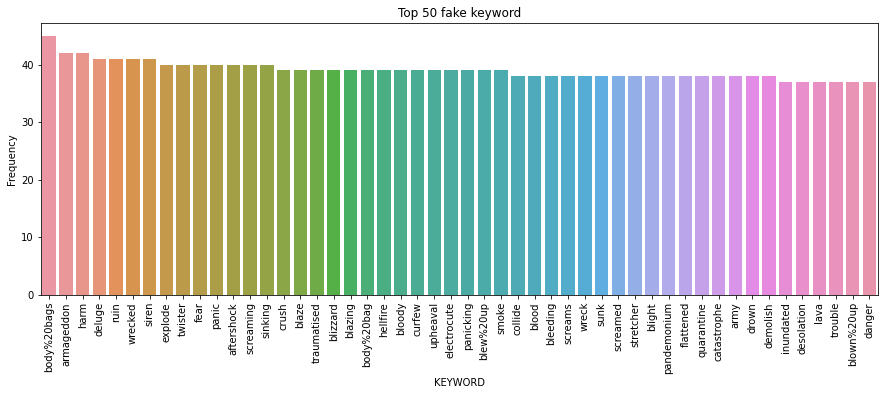

In [14]:
keywords.freq_plot('fake')

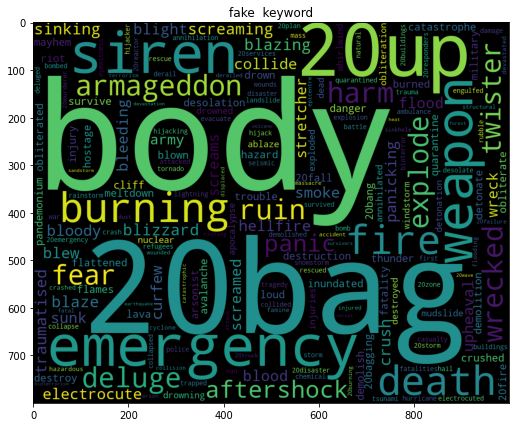

In [15]:
keywords.word_cloud('fake')

##### Observations
<ol>
     The words present for column keywords in whose target label is real are
    <li>bag</li>
    <li>body</li>
    <li>emergency etc</li>
    
</ol>    

<strong>Keytake away from keyword column</strong>
<ol>
    <li>As we keenly observe both real and fake word clouds are having unique words by which we can consider this keyword column as one of the important feature that might help us for model predictions</li>

### Location

In [16]:
# Lets see at random locations
for i in range(10):
    r  = np.random.randint(data.shape[0])
    print(data.location.iloc[r])
    print('---'*5)

Penn Hills, PA
---------------
United States
---------------
Wahpeton, ND
---------------
nan
---------------
nan
---------------
nan
---------------
nan
---------------
nan
---------------
Savannah, GA
---------------
nan
---------------


In [17]:
data.location.value_counts()

USA                           104
New York                       71
United States                  50
London                         45
Canada                         29
                             ... 
Wrex                            1
Mooresville, NC                 1
Nantes, France                  1
Baker City Oregon               1
en el pais de los arrechos      1
Name: location, Length: 3341, dtype: int64

<strong>There are very lot of unique words in the location i.e 3341<strong>

#### All Locations

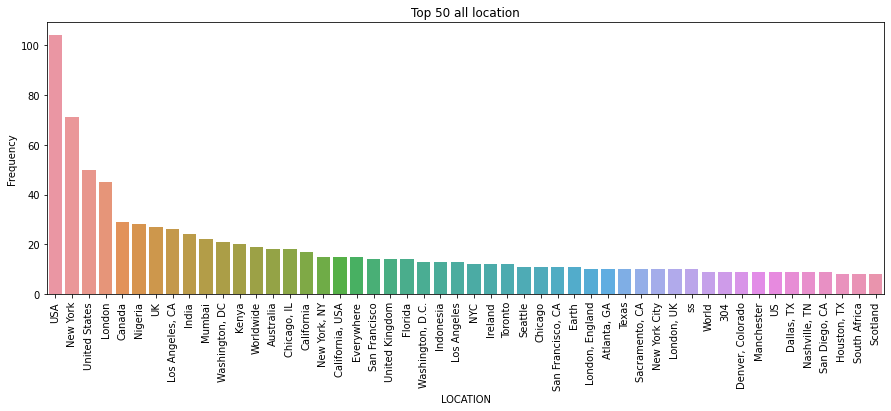

In [18]:
location = eda(data,'location')
location.freq_plot('all')

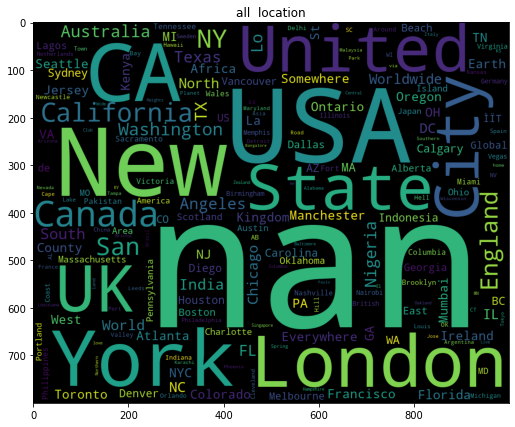

In [19]:
location.word_cloud('all')

#### Real Location

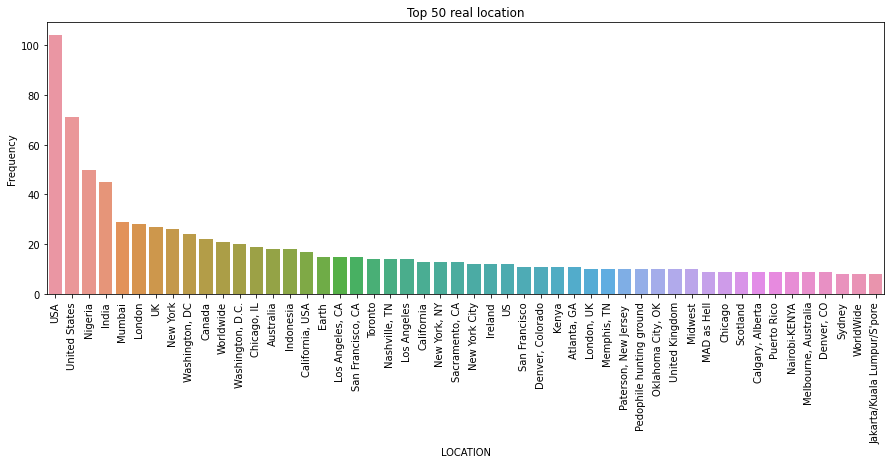

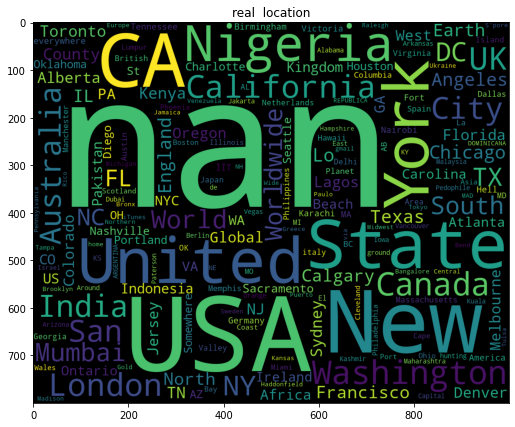

In [20]:
location.freq_plot('real')
location.word_cloud('real')

##### Observations
<ol>
     The words present for column location in whose target label is real are
    <li>nan</li>
    <li>usa</li>
    <li>united etc</li>
    
</ol>    

#### Fake Locations

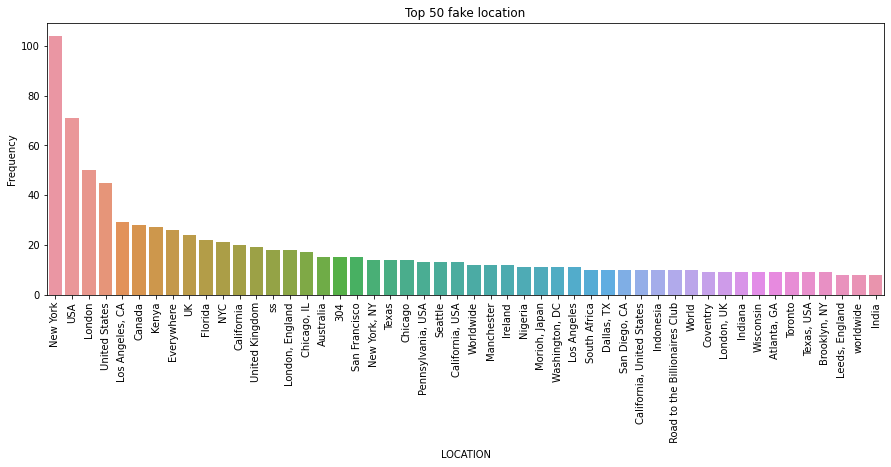

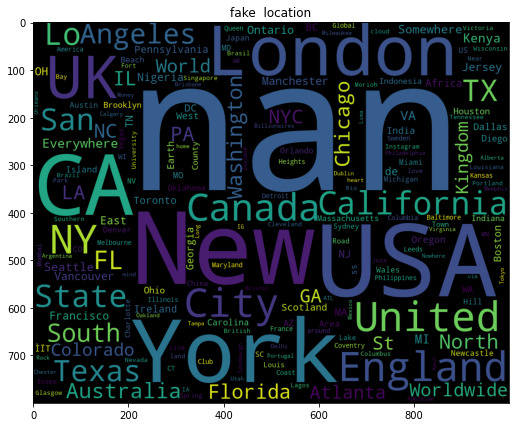

In [21]:
location.freq_plot('fake')
location.word_cloud('fake')

##### Observations
<ol>
     The words present for column location in whose target label is real are
    <li>nan</li>
    <li>usa</li>
    <li>united etc</li>
    
</ol>    

<strong>It seams there are lot of nan values, lets see the frequency of nan values in the location</strong>

In [22]:
data.location.fillna('nan').value_counts()

nan                  2533
USA                   104
New York               71
United States          50
London                 45
                     ... 
Mooresville, NC         1
Nantes, France          1
Baker City Oregon       1
Honolulu,Hawaii         1
PARACHUTE               1
Name: location, Length: 3342, dtype: int64

<strong> There are 2533 nan values for location</strong>

In [23]:
print("i.e {:.2f}%  of them are nan values".format(2533/data.shape[0]))

i.e 0.33%  of them are nan values


<strong>Keytake away from keyword column</strong>
<ol>
    <li>As we keenly observe both real and fake word clouds are having lot of common words by which we can say that considering this location column as important feature that might not help us for model predictions</li>

</ol>
<strong>Location column is not considered for training the model</strong>   

### Text

In [24]:
for i in range(10):
    r = np.random.randint(10)
    print(data.text.iloc[r])
    print('---'*5)
    

All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
---------------
I'm afraid that the tornado is coming to our area...
---------------
There's an emergency evacuation happening now in the building across the street
---------------
Forest fire near La Ronge Sask. Canada
---------------
Forest fire near La Ronge Sask. Canada
---------------
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
---------------
I'm afraid that the tornado is coming to our area...
---------------
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
---------------
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
---------------
There's an emergency evacuation happening now in the building across the street
---------------


#### Word Cloud  
##### All text

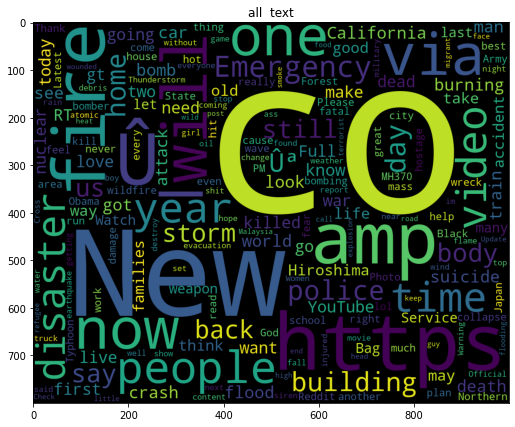

In [25]:
text = eda(data,'text')
text.word_cloud('all')

##### Observations
<ol>
     The words present for column text are
    <li>https(lot of urls might present)</li>
    <li>fire</li>
    <li>co etc</li>
    <li>u_new</li>
    
</ol>    

##### Real

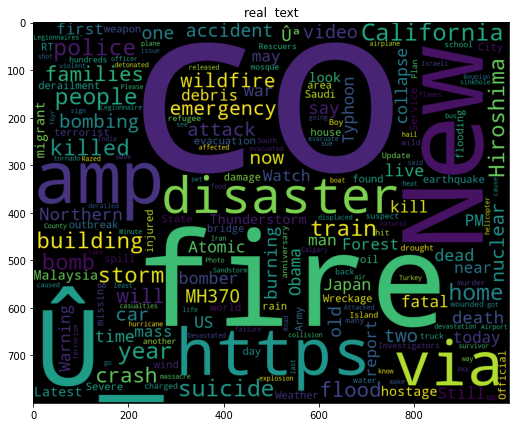

In [26]:
text.word_cloud('real')

##### Observations
<ol>
     The words present for column text are
    <li>https</li>
    <li>fire</li>
    <li>co</li>
</ol>    

##### Fake

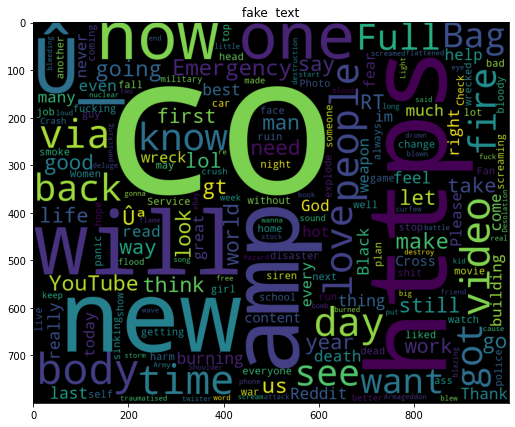

In [27]:
text.word_cloud('fake')

### Observations:
<ol>
    <li>There are lot of common words between real and fake text column data</li>
    <li>Even though there are common words in both real and fake word cloud of text column, since this is a sentance lets try out some more eda with hand crafted features on the sentances as shown below</li>
    <li>There is lot of noise in the data which must be cleaned like urls, special characters</li>
</ol>
<ol>
    <li><strong>char_count:</strong> number of characters in text</li>
    <li><strong>word_count:</strong> number of words in text</li>
    <li><strong>unique_word_count:</strong> number of unique words in text</li>
    <li><strong>stop_word_count:</strong> number of stop words in text</li>
    <li><strong>url_count:</strong> number of urls in text</li>
    <li><strong>mean_word_length:</strong> average character count in words</li>
    <li><strong>punctuation_count:</strong> number of punctuations in text</li>
    <li><strong>hashtag_count:</strong> number of hashtags (#) in text</li>
    <li><strong>mention_count:</strong> number of mentions (@) in text    </li>
    
</ol>    

In [28]:
# downloading stopwords 
nltk.download('stopwords')

stop_words = stopwords.words('english')
lemmatizer=nltk.stem.WordNetLemmatizer()
stemit    = nltk.stem.SnowballStemmer('english')



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hemanth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
# coverting values(sentance) in text columns as string type
data.text  =  data.text.apply(lambda x:str(x))

In [30]:
hand_craft_text = pd.DataFrame()
hand_craft_text['id']         = [i for i in range(data.shape[0])]
hand_craft_text['text']       = data.text
hand_craft_text['char_count'] = data.text.apply(lambda x:len(x))
hand_craft_text['word_count'] = data.text.apply(lambda x:len(x.split()))
hand_craft_text['stop_word_count'] = data.text.apply(lambda x:len([i for i in x.split() if i in stop_words]))
hand_craft_text['url_count'] = data.text.apply(lambda x:len([i for i in x.split() if 'http' in i]))
hand_craft_text['mean_word_length'] = data.text.apply(lambda x:np.mean([len(i) for i in x.split()]))
hand_craft_text['punctuation_count']= data.text.apply(lambda x:len([i for i in x if i in string.punctuation]))
hand_craft_text['hashtag_count']    = data.text.apply(lambda x:len([i for i in x if '#' in i]))
hand_craft_text['mention_count']    = data.text.apply(lambda x:len([i for i in x if '@' in i]))
hand_craft_text['target']           = data.target

hand_craft_text

,id,text,char_count,word_count,stop_word_count,url_count,mean_word_length,punctuation_count,hashtag_count,mention_count,target
0,0,Our Deeds are the Reason of this #earthquake M...,69,13,5,0,4.384615,1,1,0,1
1,1,Forest fire near La Ronge Sask. Canada,38,7,0,0,4.571429,1,0,0,1
2,2,All residents asked to 'shelter in place' are ...,133,22,9,0,5.090909,3,0,0,1
3,3,"13,000 people receive #wildfires evacuation or...",65,8,1,0,7.125000,2,1,0,1
4,4,Just got sent this photo from Ruby #Alaska as ...,88,16,6,0,4.500000,2,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...
7608,7608,Two giant cranes holding a bridge collapse int...,83,11,2,1,6.636364,5,0,0,1
7609,7609,@aria_ahrary @TheTawniest The out of control w...,125,20,7,0,5.300000,5,0,2,1
7610,7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,65,8,1,1,7.250000,11,0,0,1
7611,7611,Police investigating after an e-bike collided ...,137,19,5,0,6.263158,5,0,0,1


#### Distribution plots for handcrafted features

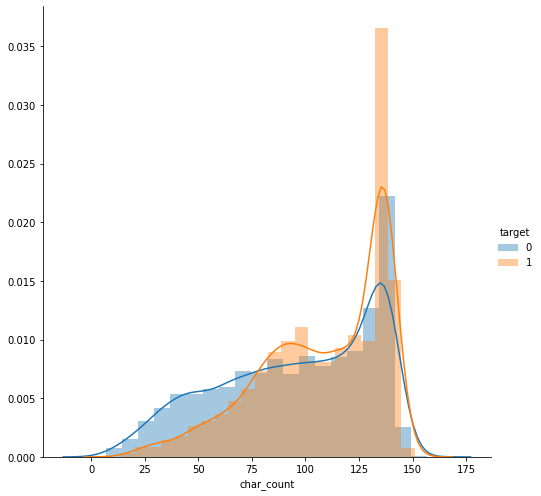

In [31]:
char_count = eda(hand_craft_text,'char_count')
char_count.dist_plot()


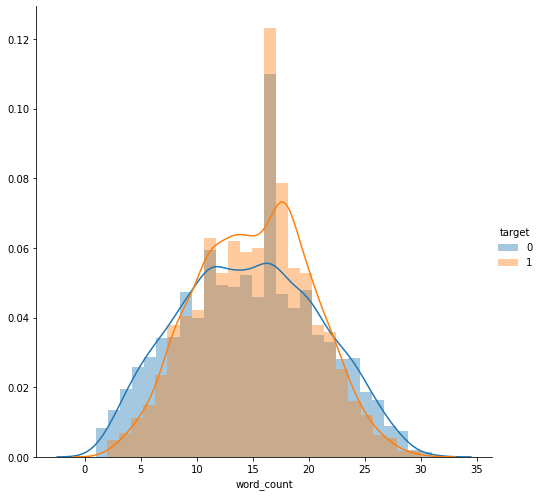

In [32]:
word_count = eda(hand_craft_text,'word_count')
word_count.dist_plot()

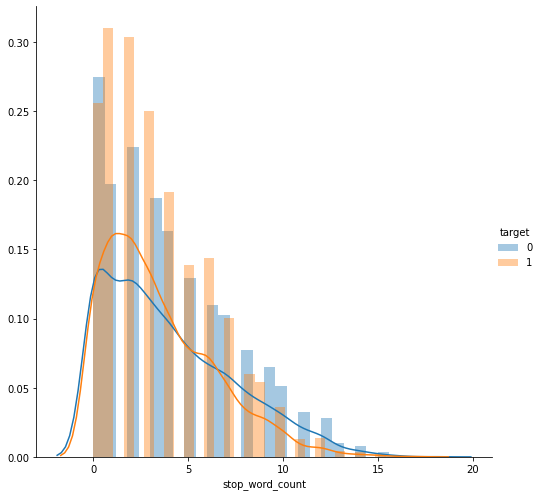

In [33]:
stop_word_count = eda(hand_craft_text,'stop_word_count')
stop_word_count.dist_plot()

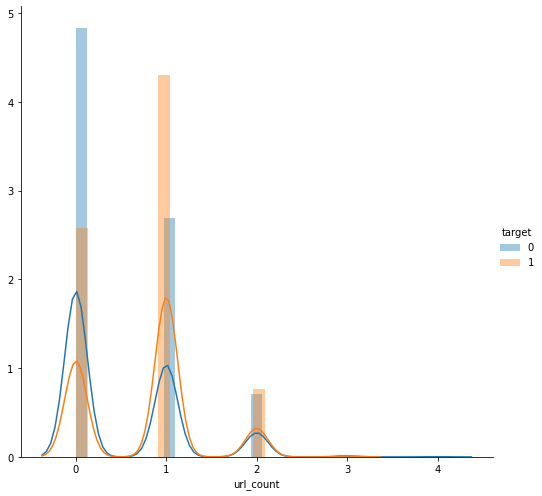

In [34]:
url_count = eda(hand_craft_text,'url_count')
url_count.dist_plot()

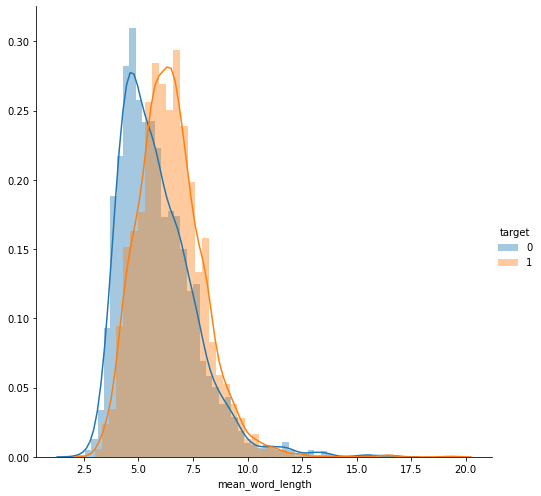

In [35]:
mean_word_length = eda(hand_craft_text,'mean_word_length')
mean_word_length.dist_plot()

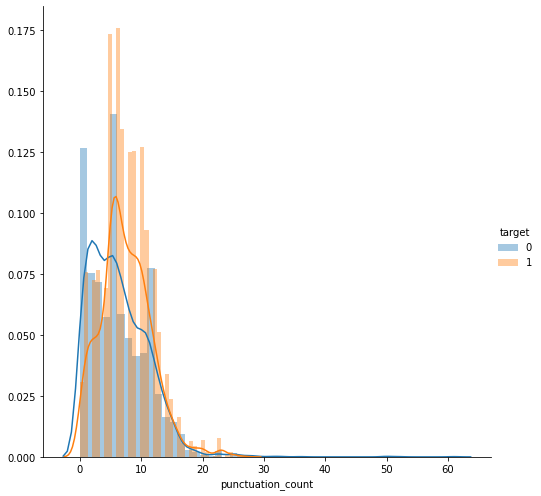

In [36]:
punctuation_count = eda(hand_craft_text,'punctuation_count')
punctuation_count.dist_plot()

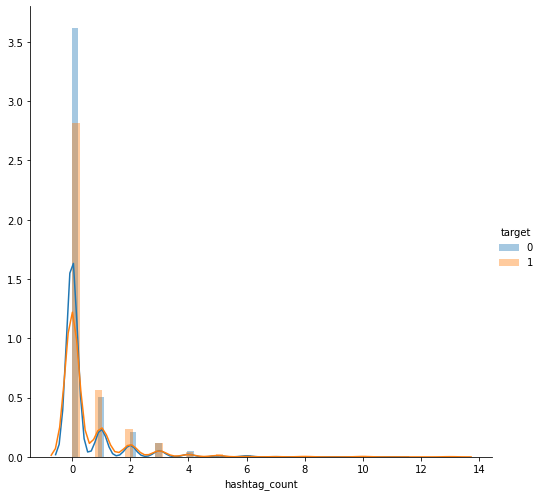

In [37]:
hashtag_count = eda(hand_craft_text,'hashtag_count')
hashtag_count.dist_plot()

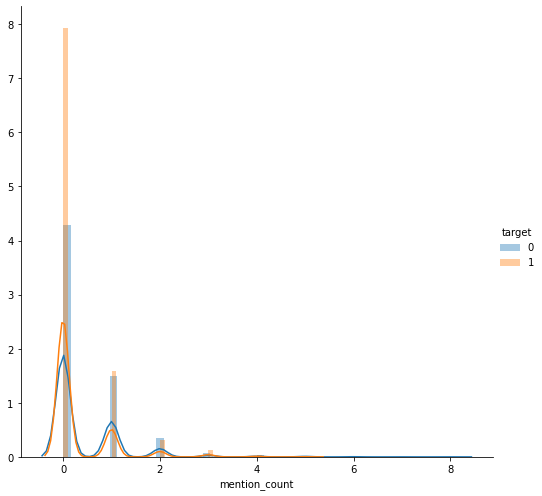

In [38]:
mention_count = eda(hand_craft_text,'mention_count')
mention_count.dist_plot()

#### Observations
<ol>
    <li>Seems that mention,hashtag and url count do not provide more information</li>
    <li>Remaining all hand crafted features provide us useful information and those features may help us predicting better result</li>
</ol>    
<strong>Key take away:</strong>
<p>we shall consider char_count,word_count,unique_word_count,stop_word_count,mean_word_length,punctuation_count features since they give some important information about the text and few of them may help in building the model
    Ex:If mean_word_length is less than 5 then there is high likely that the data point belong to class 0(fake) and if mean_word_length is more than 6 then there is high likelyy that the data point belong to class 1(real)
</p>    

### Preprocessing Data

#### Keywords

In [39]:
for i in range(1,10):
    r = np.random.randint(1000)
    print(data.keyword.iloc[r])
    print('----'*10)
        

blood
----------------------------------------
attacked
----------------------------------------
bleeding
----------------------------------------
blight
----------------------------------------
bloody
----------------------------------------
blight
----------------------------------------
ambulance
----------------------------------------
annihilated
----------------------------------------
airplane%20accident
----------------------------------------


<strong>Replacing %20 with "_" and stemming the keyword</strong>

In [40]:
data['keyword'] = data.keyword.apply(lambda x:stemit.stem(str(x).replace('%20','_').lower()))



In [41]:
for i in range(1000,1010):
    r = np.random.randint(i)
    print(data.keyword.iloc[r])
    print('----'*10)
        

bioterror
----------------------------------------
attack
----------------------------------------
body_bag
----------------------------------------
blight
----------------------------------------
blizzard
----------------------------------------
bloodi
----------------------------------------
attack
----------------------------------------
blown_up
----------------------------------------
aftershock
----------------------------------------
blizzard
----------------------------------------


### Text

In [42]:
for  text in data.text:
    print(text)
    print('---'*5)

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
---------------
Forest fire near La Ronge Sask. Canada
---------------
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
---------------
13,000 people receive #wildfires evacuation orders in California 
---------------
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
---------------
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
---------------
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
---------------
I'm on top of the hill and I can see a fire in the woods...
---------------
There's an emergency evacuation happening now in the building across the street
---------------
I'm afraid that the tornado is coming to our area...
---------------
Three people died from the heat wave so fa

---------------
Los Angeles Times: Arson suspect linked to 30 fires caught in Northern ... - http://t.co/xwMs1AWW8m #NewsInTweets http://t.co/TE2YeRugsi
---------------
Mourning notices for stabbing arson victims stir Û÷politics of griefÛª in Israel http://t.co/eug6zHciun
---------------
Mourning notices for stabbing arson victims stir Û÷politics of griefÛª in Israel http://t.co/KkbXIBlAH7
---------------
The Sound of Arson
---------------
Owner of Chicago-Area Gay Bar Admits to Arson Scheme http://t.co/MYhOHvrHiL #LGBT | https://t.co/TM5HTHFDO0
---------------
Wait What??? http://t.co/uAVFRtlfs4 http://t.co/85G1pCcCXG
---------------
Arson suspect linked to 30 fires caught in Northern California http://t.co/EJ2GHNAfHY
---------------
Trial Date Set for Man Charged with Arson Burglary http://t.co/WftCrLz32P
---------------
After death of Palestinian toddler in arson
attack Israel cracks down on Jewish
---------------
Palestinian Teen Killed Amid Protests Against Arson Attack http:/

@SexyDragonMagic I've come to the realization that I just don't have the attention span for mass battle games. Both painting and playing.
---------------
@DetroitPls interested to see who will win this battle
---------------
Battle of the GOATS  https://t.co/ofECs6tcvC
---------------
STAR WARS POWER OF THE JEDI COLLECTION 1 BATTLE DROID HASBRO - Full read by eBay http://t.co/yI30ZgiZsW http://t.co/2jGVhw7YZs
---------------
Black Eye 9: A space battle occurred at Star O784 involving 2 fleets totaling 4103 ships with 50 destroyed
---------------
#LonePine remembered around Australia as 'descendants' grow via @666canberra #Gallipoli #WW1
http://t.co/T4fvVnRPc5 http://t.co/0zZnbVFUVO
---------------
how did I miss that Gary Busey's son plays DIXIE on his electronic green fiddle during the post-battle celebration sequence
---------------
News: FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/xteZGjfs8A
---------------
FedEx no longer will transport b

My sister Rl Burned All Her Boyfriend Clothes Recorded It &amp; Sent It to him ????
---------------
@kennethbauer_ more like coffee and noodles 

Burned
---------------
Just burned the crap out of my grilled cheese sandwich. Sure wish I had a few life skills figured out by now...
---------------
I joked about it but Wood has to be burned out from working so many innings so often. #CubsTalk
---------------
Mad River Complex fires have burned 14028 acres 8% contained: The Mad River Complex fires in Trinity County ... http://t.co/LfNIPpNOtO
---------------
@thomasvissman22 @KeithyyL Keithyy gettin burned outta the blocks and on social media.... http://t.co/dlkuFtLQnF
---------------
I burned myself today on the oven ?? it was at 500 degrees ??
---------------
Watch how bad that fool get burned in coverage this year. Dat dude is all-pro practice squad material
---------------
I PUT MY CHICKEN NUGGETS IN THE MICROWAVE FOR 5 MINUTES INTEAD OF 1 ON ACCIDENT AND THEY FUCKING BURNED
-----------

Sign the petition @david_cameron to protect bees instead of toxic chemical companies want to harm them! #savebees  - http://t.co/dB7ft3Yi6d
---------------
USA: BREAKING NEWS: CHEMICAL SPILL/EVACUATIONS/RED CROSS EMERGENCY http://t.co/007Npen6LG
---------------
New #job opening at Downtown Emergency Service Center in #Seattle - #Chemical #Dependency Counselor or Intern #jobs http://t.co/BNRdKgXavr
---------------
Emergency crews respond to chemical spill downtown beaumont #benews http://t.co/PME0HOJVYA
---------------
Explosion at chemical site leads to building collapse near Krefeld Germany. Emergency crews on scene; avoid the area. #iJETalerts
---------------
Bomb Crash Loot Riot Emergency Pipe Bomb Nuclear Chemical Spill Gas Ricin Leak Violence Drugs Cartel Cocaine Marijuana Heroine Kidnap Bust
---------------
Google Alert: Emergency units simulate a chemical explosion at NU http://t.co/NDgpWYxu6H
---------------
Downtown Emergency Service Center is hiring! #Chemical #Dependency Cou

---------------
RT AbbsWinston: #Zionist #Terrorist demolish 18 #Palestinian structures in Jordan Valley http://t.co/rg3BndKXjX
Û_ http://t.co/Bq90pfzMrP
---------------
@MarioMaraczi I'm watching it right now.  He freaked out after the 1st.  First fight where he didn't demolish the guy
---------------
Think Akwa Ibom!: DonÛªt come to Uruan and demolish buildings again ex-Assembly member warns Udom Emmanuel  http://t.co/1cnw6NSka5
---------------
Read this already in '14 but it was and remains one of my favorite articles ever. ?'LetÛªs Like Demolish Laundry'? http://t.co/6suPThAece
---------------
Imagine having KP AND Root.... We'd demolish everyone
---------------
Absurdly Ridiculous MenÛªs #Fashion To Demolish You #Manhood. http://t.co/vTP8i8QLEn
---------------
The far right racist #AvigdorLiberman calls for destruction of #Susiya ! Previously he also called for beheadings!   http://t.co/Li8otXt8hh
---------------
I could demolish this right now! https://t.co/SkS5jCCrj2
-------

---------------
@KaiSeiw And then there's people like me where my whole people are named Desolation
---------------
This desperation dislocation
Separation condemnation
Revelation in temptation
Isolation desolation
Let it go and so to find away
---------------
#4: The Hobbit: The Desolation of Smaug (Bilingual) http://t.co/G5dO2X6226
---------------
Winter Desolation of Death is also on Tumblr:  http://t.co/93DM6gnWwC  Al Necro's reviews interviews &amp; more!
---------------
#np agalloch - the desolation song
---------------
Imagini noi si 2 clipuri The Hobbit: The Desolation of Smaug -... http://t.co/j6CfwUKofE #cliptv #desolationofsmaug #poze #thehobbit
---------------
Fear and panic in the air
I want to be free
From desolation and despair
And I feel like everything I sow ? http://t.co/iXW2cUTk1C
---------------
My Chemical Romance ÛÓ Desolation Row #np
---------------
Putin's plan to destroy Western food en masse is causing a huge public backlash http://t.co/FAJbxz5kar
-----------

[Question] Is anybody else having this problem with the '7' circle in Epicentre? via /r/jailbreak http://t.co/48TPnmbJVG
---------------
I feel like if MKayla and Cee ever got in the same room everyone should evacuate because it would be so petty and childish I couldn't deal
---------------
CHICAGO (AP) ÛÓ Organizers of Lollapalooza say they are reopening the music festival after the threat of a storm prompted them to evacuate
---------------
Learn how to evacuate your home in the event of a #wildfire view videos at http://t.co/bGeRLjamTE #CA #NV #UT #CO #OR http://t.co/sPuHuvgAsy
---------------
Disaster control teams are studying ways to evacuate the port area in response to tidal wave warnings.[900037]
---------------
'So again make sure to evacuate past the fire doors. Any questions? Yes?'
'Why would we open the doors to the fire!!?!??!?'

I...I..I cant
---------------
When there's a fire alarm going off in zehrs and we keep working for 20 minutes then decide to evacuate everyone.

It's lights out again with stage-two load shedding: Stage-two load shedding will be in force between 5pm and 10pm. http://t.co/vxVfAEEY0q
---------------
DK Eyewitness Travel Guide: Denmark: travel guide eBay auctions you should keep an eye on: http://t.co/xpwkodpqtO
---------------
WFTV Eyewitness News: FBI: Man who stole US secrets 'married' Honduran minors for sex http://t.co/NdwEp6IZDQ
---------------
Freed #BokoHaram captives speak up: ÛÏI will make sure she goes to school.' @guardian http://t.co/PK8dgVripw http://t.co/RZ0adzursW
---------------
'I tried to save Mido Macia': One of the murder accused has testified he tried to save Mido MaciaÛªs life. http://t.co/vxVfAEEY0q
---------------
Russian 'food crematoria' provoke outrage amid crisis famine memories: MOSCOW (Reuters) - Russian government ... http://t.co/Mphog0QDDN
---------------
@OCT336 guys these bitches ain't famine then ??
---------------
'Food crematoria' provoke outrage amid crisis famine memories... http://t.co/fA

---------------
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'
---------------
Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife
---------------
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'
---------------
@DeeDee_Casey been on tour in the day to Hellfire caves! Would love to investigate the place though!
---------------
Beware of your temper and a loose tongue! These two dangerous weapons combined can lead a person to the Hellfire #islam!
---------------
HELLFIRE EP - SILENTMIND &amp; @_bookofdaniel  https://t.co/FKqJY3EzyG
---------------
#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect
---------------
Beware of your temper and a loose tongue! These two dangerous weapons combined can lead a person to the Hellf

---------------
Check this @SuryaRay Udhampur terror attack: Militants attack police post 2 SPOs injured:Û_ http://t.co/ptq3zMgncK #SuryaRay #India
---------------
Arian Foster does keep his promise... And that's to get injured every yeat
---------------
#WakeUpFlorida... #Floridians more likely to be killed/injured by a #TrophyHunt killer's gun than by ISIS.  https://t.co/j5In8meXAJ
---------------
@RVacchianoNYDN The only surprise is that they aren't ALL injured.
---------------
@chikislizeth08 you're not injured anymore? ??
---------------
Top Stories - Google 4 dead dozens injured in Gaza blast near house leveled in summer warÛ_ http://t.co/P3o71DZ992
---------------
Photos: 17 people killed and over 25 injured in deadly Saudi Mosque suicide attack http://t.co/geEKnwJJSz
---------------
http://t.co/qr3YPEkfOe 
Seems they declared war against government..
---------------
Udhampur terror attack: Militants attack police post 2 SPOs injured http://t.co/zMWeCBWVaO
---------------
If I

---------------
Alabama firefighters quarantined after possible Ebola exposure http://t.co/hzpX6vAQPZ reports http://t.co/L4W0PCorbs
---------------
0nPzp mhtw4fnet

Officials: Alabama Home Quarantined Over Possible Ebola Case - ABC News
---------------
Alabama home quarantined over possible #Ebola case: An ambulance sat outside the University of Alabama atÛ_ http://t.co/y2JT1aMyFJ
---------------
#hot  Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/HqdCZzdmbN #prebreak #best
---------------
Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/gix1gaYnXZ http://t.co/P93S2rFhx6
---------------
Hey @reddit - the concept of a 'quarantine' makes no sense if the people you've quarantined can just wander out &amp; about whenever they want
---------------
Ebola: Alabama Home Quarantined Over Possible Ebola Case.. Related Articles: http://t.co/BiigD1LEq3
---------------
oc73x mhtw4fnet


Japan FUSO Class Battleship YAMASHIRO Naval Cover 1999 PHOTO Cachet SUNK WWII http://t.co/Aq5ZliM7l4 http://t.co/FvR9jDQ71a
---------------
'Blaaaaaaa' he said as he sunk his face into your stomach making it vibrate @ResoluteVanity
---------------
Hasn't quite sunk in that I saw Johnny Marr and Primal Scream all in the space of a few hours on Sunday
---------------
@CodeMeW Were you opening regular or master packs? RT: soÛ_ sunkÛ_1 mil credits into light sideÛ_ didn't pullÛ_oneÛ_you sure about those odds?
---------------
Yup. Still hasn't sunk in. ?? https://t.co/Ii2SpVP89b
---------------
@SaintRobinho86 someone has to be at the bottom of every league. Tonight clearly demonstrated why the Lions are where they are - sunk!
---------------
It still hasn't sunk in that I've actually met my Idol ????
---------------
@UntamedDirewolf 'I... Wow. Alright.' Sansa shook her head and blinked rapidly as the new information sunk in. 'I really don't know what--
---------------
@BenAffleck  i r

---------------
Having your wounds kissed by Someone who doesn't see them as disasters in your soul but rather cracks to pour their love into is amazing.
---------------
@FEVWarrior -in the Vault that could take a look at those wounds of yours if you'd like to go to one of these places first.' Zarry has had-
---------------
Cutting for some celebrety and then posting the wounds online is a no-go.
---------------
If time heals all wounds how come the belly button stays the same?
---------------
and I thought my surgical wounds were healed!!! this weather ain't helping either ):
---------------
Woodlawn Shooting Wounds 79-Year-Old Woman Teen - Woodlawn - http://t.co/nu3XXn55vS Chicago http://t.co/XNGrfNQSx3
---------------
It is not always friendship when kisses show up neither is it always enemity that shows up when wounds show up. #BishopFred
---------------
I keep scrolling to find out what he said or did....but there seems to be no exact starting point.  Wounds run deep. : /
--------

<strong>Since this is tweet data there will short cuts used and if you observe datapoint at 7610 below there is somthing like time stamp in text i.e M1.94[01:04 UTC]?, so  our work is to remove those special patterns and special characters</strong>

In [43]:
data.text.iloc[7610]

'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ'

In [44]:
data

,id,keyword,location,text,target
0,1,nan,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,nan,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,nan,NaN,All residents asked to 'shelter in place' are ...,1
3,6,nan,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,nan,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,nan,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,nan,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,nan,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,nan,NaN,Police investigating after an e-bike collided ...,1


<strong>First lets check datapoints with "M1.94[01:04 UTC]?" pattern</strong>

In [45]:
for j,i in enumerate(data.text):
    if ' UTC]?' in i:
        print(j,i)

3053 M1.57 [01:11 UTC]?3km NNW of Lake Henshaw California. http://t.co/f9KQksoSw3
7140 M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ
7610 M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ


<strong>So, lets remove above data points since they are having unusual text</strong>

In [46]:
for i in range(data.shape[0]):
    if i == 3053 or i == 7140 or i == 7610:
        data.text.iloc[i] = ''
        

/home/hemanth/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [47]:
# below abbreviations are taken from :- https://www.kaggle.com/rftexas/text-only-kfold-bert
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [48]:
def clean_text(text):
    
    '''Given a string data this function performs cleaning operations like
       replacing abbreviations with their proper meaning
       replaceing digits with coma into normal digit Ex: 13,000 --> 13000
    '''
    
    text = text.lower()
    for word in text.split():
        if word in list(abbreviations.keys()):
            text = text.replace(word,abbreviations[word])
    
    if re.search(r'\d+\,\d+',text):
        t = re.search(r'\d+\,\d+',text)
        text = text[:t.span()[0]]+" "+text[t.span()[0]:t.span()[1]].replace(',','')+" "+text[t.span()[1]:]
        
    
    text = re.sub('https?://[A-Za-z0-9./]+',' ',text)# Replacing urls
    text = re.sub(r'@[A-Za-z0-9]+',' ',text)# Replcing mentions Ex: @hemanth
    text = re.sub(r'[^A-Za-z0-9]+',' ',text)# Replacing special characters with space
    text = re.sub(r'\s+',' ',text)# Replacing extra spaces with single space
    
    #Removing stopwords and stemming the words to decrease dimentionality of data after vectorization/featurization\
    # and to normalizing the word by replacing with its root word.
    
    text = ' '.join([stemit.stem(word) for word in text.split() if word not in stopwords.words('english')])
    return text
    

In [49]:
data['clean_text'] = data.text.apply(lambda x: clean_text(x))

In [50]:
data

,id,keyword,location,text,target,clean_text
0,1,nan,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us
1,4,nan,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada
2,5,nan,NaN,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...
3,6,nan,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 peopl receiv wildfir evacu order california
4,7,nan,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...
...,...,...,...,...,...,...
7608,10869,nan,NaN,Two giant cranes holding a bridge collapse int...,1,two giant crane hold bridg collaps nearbi home
7609,10870,nan,NaN,@aria_ahrary @TheTawniest The out of control w...,1,ahrari control wild fire california even north...
7610,10871,nan,NaN,,1,
7611,10872,nan,NaN,Police investigating after an e-bike collided ...,1,polic investig e bike collid car littl portug ...


<strong>So, finally joining handcrafted dataframe and data </strong>

In [51]:

final_data = data.drop(['location'],axis=1).set_index('id').join(hand_craft_text.drop(['target','text','mention_count','hashtag_count','url_count'],axis=1).set_index('id'))
final_data.head()

,keyword,text,target,clean_text,char_count,word_count,stop_word_count,mean_word_length,punctuation_count
id,,,,,,,,,
1,nan,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us,38.0,7.0,0.0,4.571429,1.0
4,nan,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada,88.0,16.0,6.0,4.500000,2.0
5,nan,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...,110.0,18.0,3.0,5.166667,7.0
6,nan,"13,000 people receive #wildfires evacuation or...",1,13000 peopl receiv wildfir evacu order california,95.0,14.0,2.0,5.857143,3.0
7,nan,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...,59.0,15.0,8.0,3.000000,4.0


In [52]:
# data.to_csv('data/clean_data.csv',index=False)
# data.to_csv('data/stopped_stemmed.csv',index=False)

In [53]:
final_data.to_csv('data/final_data.csv',index=False)

<strong>Lets featurize/vectorize the data in next document</strong>